# **Overview**

This script evaluates the performance of an **automated segmentation model** for medical images by comparing its results to manually labeled ground truth data. The comparison is based on **Dice similarity coefficients (DSC)**. The script computes both **global DSC** and **label-specific DSC** (for labels 1 to 4), saves the results in a CSV file, and visualizes the distribution of global DSC scores.

---

## **Key Steps**

### **1. Setup and File Matching**
- Define directories for manual and automated segmentation files.
- Extract patient IDs from filenames and match them with the corresponding segmentation files.

### **2. Segmentation Comparison and Metric Calculation**
- Read manual and automated segmentations using **SimpleITK**.
- Compute:
  - **Global Dice coefficient**: Measures overall segmentation accuracy.
  - **Label-specific Dice coefficients** (1 through 4): Measures accuracy for each specific region or label.

### **3. Results Storage**
- Save the computed metrics (global and label-specific DSC) into a **CSV file** for future analysis.

### **4. Visualization**
- Generate a **histogram** of global Dice coefficients to visualize the distribution.
- Calculate and display **summary statistics**, including mean and standard deviation of the global DSC scores.

---


In [1]:
# Import necessary libraries
from medpy.metric import binary  # For Dice similarity calculation
import pandas as pd  # For handling tabular data
import SimpleITK as sitk  # For reading and processing medical images
import numpy as np  # For array manipulations
import os  # For file handling
import matplotlib.pyplot as plt  # For plotting histograms

# Helper function to find the file path of a segmentation given the patient ID
def get_image_path_by_id(patient_id, image_dir):
    """
    Finds and returns the file path of a segmentation file based on the patient ID.
    Args:
    - patient_id (str): The ID of the patient.
    - image_dir (str): Directory containing segmentation files.

    Returns:
    - str: File path of the segmentation file.
    """
    file_name = [
        os.path.relpath(os.path.join(image_dir, x))
        for x in os.listdir(image_dir)
        if os.path.isfile(os.path.join(image_dir, x)) and patient_id in x
    ][0]
    return file_name


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Define directories for manual and automated segmentations
manual_seg_dir = 'nnUNet_raw_data_base/nnUNet_test_data/test_seg_in_nii/'
auto_seg_dir = 'nnUNet_raw_data_base/nnUNet_test_data/test_label_in_nii/'
csv_write_path = 'nnUNet_raw_data_base/nnUNet_test_data/MRI_metrics_test.csv'

# Initialize an empty DataFrame to store metrics
df_init = pd.DataFrame()

# Get all manual segmentation file paths
label_paths = []
for r, d, f in os.walk(manual_seg_dir):
    for file in f:
        if '.nii.gz' in file:
            label_path = os.path.join(r, file)
            label_paths.append(label_path)


In [5]:
# Iterate through manual segmentation files
import numpy as np
np.bool = np.bool_

i = 0
for idx, label_path in enumerate(label_paths):
    d = label_path.split('/')[-1]
    
    # Extract patient ID from the file name
    indices = [i for i, c in enumerate(d) if c == '_']
    pid = d[:indices[1]]
    if len(indices) > 2 and 'Bd' in d:
        pid = d[:indices[2]]

    # Get corresponding automated segmentation path
    auto_seg_path = get_image_path_by_id(pid, auto_seg_dir)
    manual_seg_path = get_image_path_by_id(pid, manual_seg_dir)

    # Proceed only if both files exist
    if os.path.exists(auto_seg_path) and os.path.exists(manual_seg_path):
        i += 1
        print(i, pid, 'mapped', auto_seg_path, 'yeah!!!!!!!!!\n')
        
        # Read manual and automated segmentations
        manual_seg_sitk = sitk.ReadImage(manual_seg_path)
        mskCube = sitk.GetArrayFromImage(manual_seg_sitk)
        auto_seg_sitk = sitk.ReadImage(auto_seg_path)
        prdCube = sitk.GetArrayFromImage(auto_seg_sitk)

        # Calculate global Dice similarity coefficient
        dice_score = binary.dc(prdCube, mskCube)

        # Calculate Dice scores for each segmentation label (1 to 4)
        scores = {}
        for label in range(1, 5):
            mskCube_label = np.copy(mskCube)
            prdCube_label = np.copy(prdCube)
            mskCube_label[mskCube_label != label] = 0
            prdCube_label[prdCube_label != label] = 0
            scores[f'dsc_{label}'] = binary.dc(prdCube_label, mskCube_label)

        # Append results to the DataFrame
        df = pd.DataFrame({
            'CT_id': pid,
            'dsc_global': round(dice_score, 5),
            **{key: round(value, 5) for key, value in scores.items()}
        }, index=[0])
        df_init = df_init._append(df, ignore_index=True)
        df_init.to_csv(csv_write_path)
        
        # Print progress
        print(idx, 'th pid:', pid, 'dsc', round(dice_score, 5), 'done into\n', csv_write_path)
        print('Details:', ', '.join(f'{key}: {round(value, 5)}' for key, value in scores.items()))
        print('\n\n\n')


1 TUM01_water mapped nnUNet_raw_data_base/nnUNet_test_data/test_label_in_nii/TUM01_water_manual_label_segmentation_L2-L5.nii.gz yeah!!!!!!!!!

0 th pid: TUM01_water dsc 0.98531 done into
 nnUNet_raw_data_base/nnUNet_test_data/MRI_metrics_test.csv
Details: dsc_1: 0.98248, dsc_2: 0.97796, dsc_3: 0.98087, dsc_4: 0.98421




2 TUM01_fat mapped nnUNet_raw_data_base/nnUNet_test_data/test_label_in_nii/TUM01_fat_manual_label_segmentation_L2-L5.nii.gz yeah!!!!!!!!!

1 th pid: TUM01_fat dsc 0.98429 done into
 nnUNet_raw_data_base/nnUNet_test_data/MRI_metrics_test.csv
Details: dsc_1: 0.98159, dsc_2: 0.97524, dsc_3: 0.97804, dsc_4: 0.98315






In [7]:
# Display the size and first few rows of the results DataFrame
print(df_init.shape)
print(df_init.head())

# Print mean and standard deviation of global Dice scores
print("Mean DSC:", np.mean(df_init['dsc_global']))
print("Standard Deviation DSC:", np.std(df_init['dsc_global']))
print("Total Entries:", df_init['dsc_global'].shape[0])

(2, 6)
         CT_id  dsc_global    dsc_1    dsc_2    dsc_3    dsc_4
0  TUM01_water     0.98531  0.98248  0.97796  0.98087  0.98421
1    TUM01_fat     0.98429  0.98159  0.97524  0.97804  0.98315
Mean DSC: 0.9848
Standard Deviation DSC: 0.0005100000000000104
Total Entries: 2


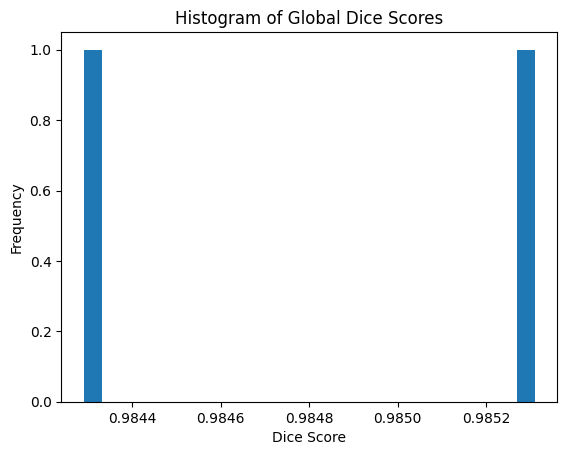

In [8]:


# Plot histogram of global Dice scores
plt.hist(df_init['dsc_global'], bins=25)
plt.title("Histogram of Global Dice Scores")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.show()

